Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip the dataset
!unzip "/content/drive/My Drive/CNN_assignment.zip" > /dev/null

In [3]:
!pip install tensorflow

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
tf.__version__

'2.15.0'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [7]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames with specified pattern.

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Training Dataset
# per instructions using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
# Per instructions resizing the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),
                                                               batch_size=batch_size,validation_split=0.2, label_mode='categorical',
                                                               subset='training',seed=123)
train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [10]:
# Validation Dataset
# Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resizing the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),
                                                             batch_size=batch_size,validation_split=0.2, label_mode='categorical',
                                                             subset='validation',seed=123)
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [11]:
# Listing all the classes of skin cancer and storing them in a list.
# The class names are in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data: visualizing one instance of all the nine classes present in the dataset


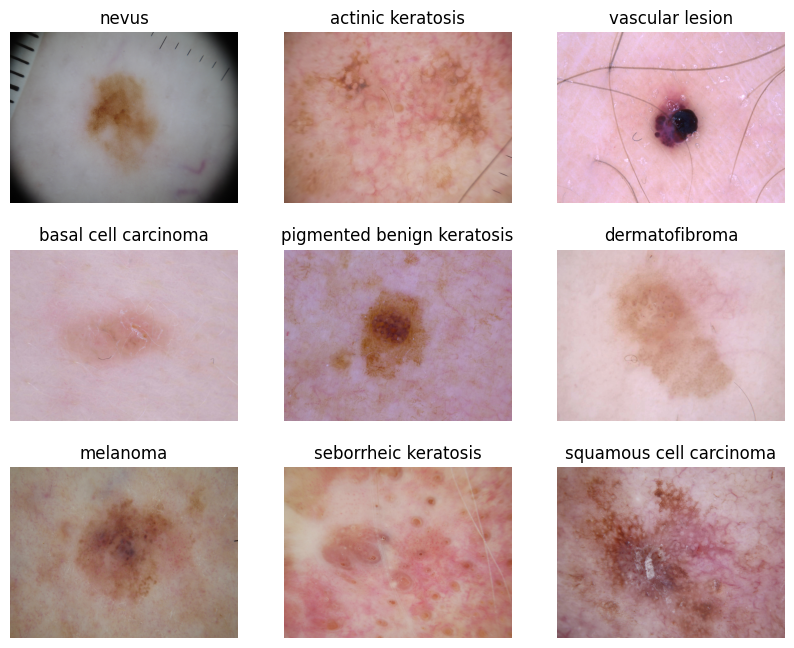

In [12]:
# Using Training dataset to visualize one instance of all the nine classes

from PIL import Image
fig=plt.figure(figsize=(10,8))
counter=1
for f in data_dir_train.iterdir():
  im=Image.open(f.iterdir().__next__())
  plt.subplot(3,3,counter)
  plt.imshow(im)
  plt.title(str(f).split('/')[-1])
  counter+=1
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Hence, it is good to standardize values to be in the `[0, 1]`

In [14]:
# Building the CNN model - Basic without drop-out layer

num_classes = 9

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choosing optimiser and loss function for model training

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [16]:
# Choosing optimiser and loss function for the model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
# so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [17]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

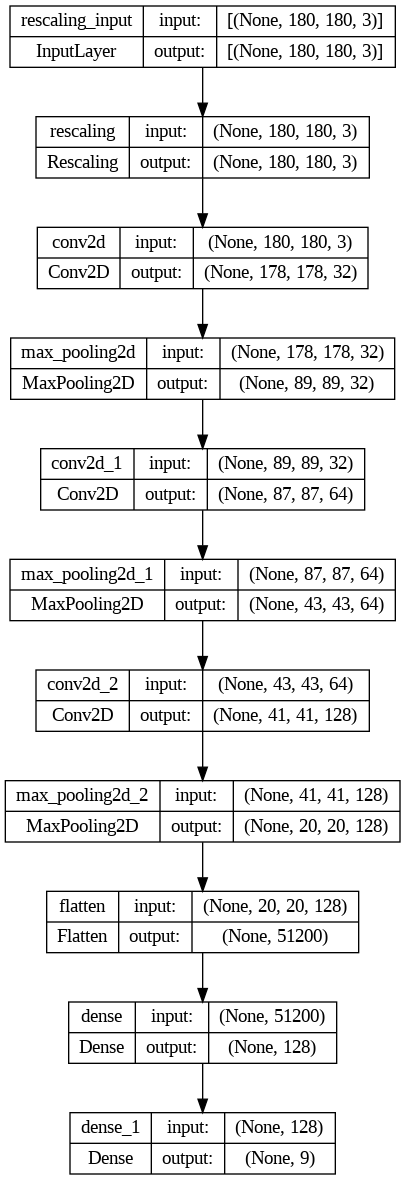

In [18]:
# Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [19]:
print(len(train_ds))

56


In [20]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 2.1148 - accuracy: 0.2313
Epoch 1: val_accuracy improved from -inf to 0.29754, saving model to model.h5
56/56 [==============================] - 32s 122ms/step - loss: 2.1098 - accuracy: 0.2327 - val_loss: 1.9306 - val_accuracy: 0.2975
Epoch 2/20
 1/56 [..............................] - ETA: 1s - loss: 2.1051 - accuracy: 0.2812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/56 [============================>.] - ETA: 0s - loss: 1.7248 - accuracy: 0.3778
Epoch 2: val_accuracy improved from 0.29754 to 0.41163, saving model to model.h5
56/56 [==============================] - 2s 39ms/step - loss: 1.7247 - accuracy: 0.3772 - val_loss: 1.5979 - val_accuracy: 0.4116
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 1.5271 - accuracy: 0.4642
Epoch 3: val_accuracy improved from 0.41163 to 0.48546, saving model to model.h5
56/56 [==============================] - 2s 36ms/step - loss: 1.5303 - accuracy: 0.4621 - val_loss: 1.4702 - val_accuracy: 0.4855
Epoch 4/20
55/56 [============================>.] - ETA: 0s - loss: 1.4376 - accuracy: 0.4903
Epoch 4: val_accuracy did not improve from 0.48546
56/56 [==============================] - 2s 32ms/step - loss: 1.4383 - accuracy: 0.4927 - val_loss: 1.6058 - val_accuracy: 0.4586
Epoch 5/20
55/56 [============================>.] - ETA: 0s - loss: 1.3434 - accuracy: 0.5364
Epoch 5: val_accuracy improved f

### Visualizing training results

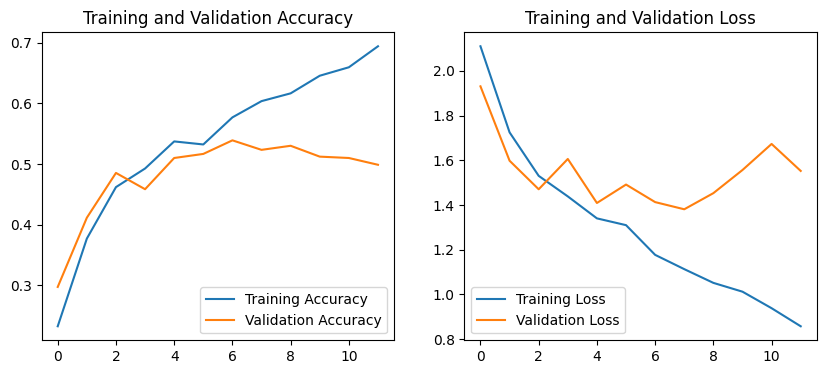

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

### Here are the oberservations -

The model is clearly overfitting -
* Training accuracy (69%) is significantly higher than the validation accuracy(49%).

In [22]:
# Since the model is overfit, let us try a suitable augmentation strategy and visual an instant of such data

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.5)
  ]
)

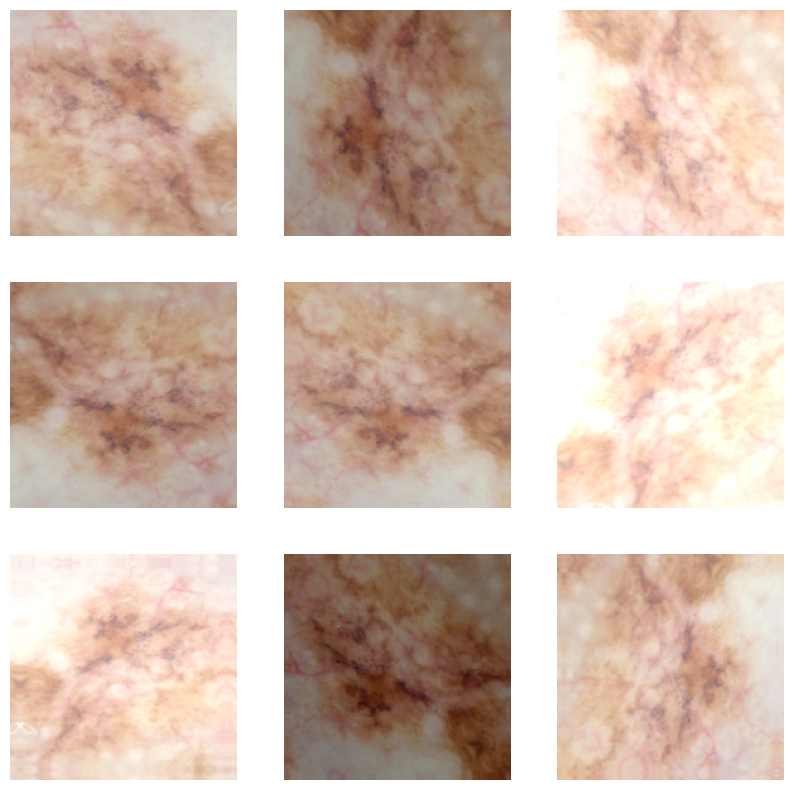

In [23]:
# Visualizing how the augmentation strategy works for one instance of training image.

for batch,labels in train_ds.take(1):
  im=batch[0]
  im=tf.reshape(im,(1,img_width,img_height,3))

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(im)[0]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

### Updating the model to include drop-out layers


In [24]:
# Let us update the model with additional convolution layer along with drop-out layers


model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fourth Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compiling the model

In [25]:
# Choosing optimiser and loss function for the model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
# so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

# Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [26]:
# Viewing the summary of the updated model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Training the model

In [27]:
# Training the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0284 - accuracy: 0.2271
Epoch 1: val_accuracy improved from -inf to 0.33781, saving model to model.h5
56/56 [==============================] - 7s 57ms/step - loss: 2.0284 - accuracy: 0.2271 - val_loss: 1.8765 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.8360 - accuracy: 0.3298
Epoch 2: val_accuracy improved from 0.33781 to 0.37584, saving model to model.h5
56/56 [==============================] - 3s 52ms/step - loss: 1.8360 - accuracy: 0.3298 - val_loss: 1.6986 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.6940 - accuracy: 0.3761
Epoch 3: val_accuracy did not improve from 0.37584
56/56 [==============================] - 3s 55ms/step - loss: 1.6940 - accuracy: 0.3761 - val_loss: 1.7126 - val_accuracy: 0.3557
Epoch 4/20
55/56 [============================>.] - ETA: 0s - loss: 1.6055 - accuracy: 0.4205
Epoch 4: val_accuracy im

### Visualizing the results

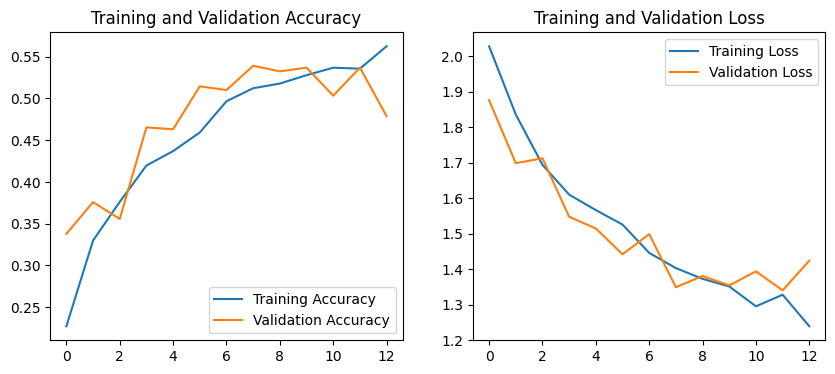

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* The model have improved from the previous run, the overfitting has been overcome a bit with the drop out layers. There is still scope of improvement as the model is underfitting (Training and validation accuracy is less than 70%).



#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


### Checking the distribution across different classes.

In [30]:
# Checking the distribution of original dataset across different classes.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Num_Images'] = original_df['Label'].value_counts()
df1 = original_df['Label'].value_counts().reset_index()
df1.columns = ['Label', 'Num_Images']
df1

,Label,Num_Images
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


<ipython-input-31-61027e2afe54>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Label", y="Num_Images", data=df1, palette = "hls",


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'pigmented benign keratosis'),
  Text(1, 0, 'melanoma'),
  Text(2, 0, 'basal cell carcinoma'),
  Text(3, 0, 'nevus'),
  Text(4, 0, 'squamous cell carcinoma'),
  Text(5, 0, 'vascular lesion'),
  Text(6, 0, 'actinic keratosis'),
  Text(7, 0, 'dermatofibroma'),
  Text(8, 0, 'seborrheic keratosis')])

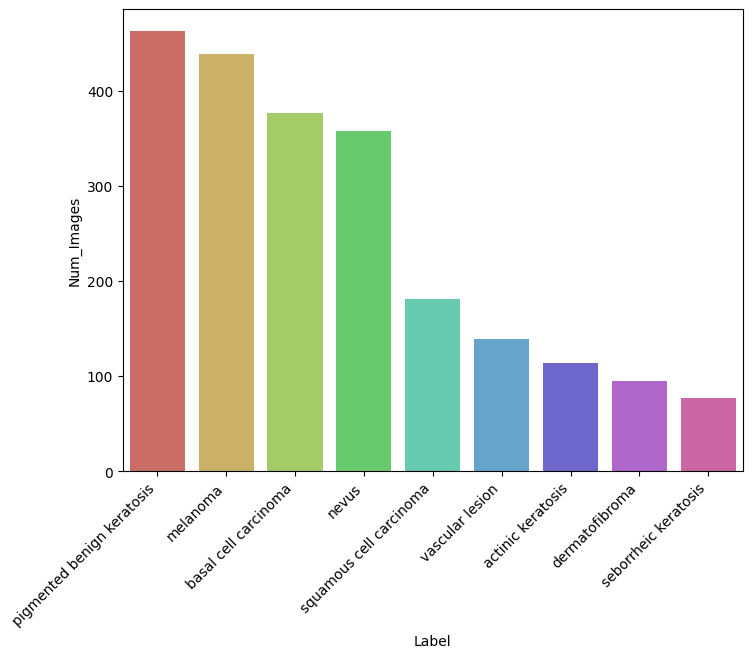

In [31]:
# Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x="Label", y="Num_Images", data=df1, palette = "hls",
            label="Distribution across Classes")
plt.xticks(rotation=45, horizontalalignment='right')

#### As we see, the distribution of datapoints(images) is not equal across all the classes.

- Which class has the least number of samples?
->Seborrheic Keratosis
- Which classes dominate the data in terms proportionate number of samples?
->Pigmented Benign Keratosis


#### Rectifying the class imbalance
#### **Context:** Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`,  the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset=str(data_dir_train)+'/' #'./Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    #p.flip_random(probability=0.5)
    #p.zoom_random(probability=0.5, percentage_area=0.8)
    #p.random_brightness(probability = 0.5, min_factor=0.5, max_factor=3.0)
    #p.random_color(probability=0.5,min_factor = 0.5, max_factor=2.0)
    p.sample(1000)

    # After several experimentation, we have used used augmentation strategy which only rotates the images.
    # Also, we are adding 1000 samples per class to make sure that none of the classes are sparse. This yielded better results than adding 500samples.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F352C5E52D0>: 100%|██████████| 1000/1000 [00:36<00:00, 27.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F34DDFB7D30>: 100%|██████████| 1000/1000 [00:36<00:00, 27.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F353C383B80>: 100%|██████████| 1000/1000 [00:29<00:00, 33.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F34B472BD30>: 100%|██████████| 1000/1000 [02:38<00:00,  6.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F353C383B80>: 100%|██████████| 1000/1000 [02:25<00:00,  6.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F34DDFB6350>: 100%|██████████| 1000/1000 [00:28<00:00, 35.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F35BEED2A40>: 100%|██████████| 1000/1000 [01:09<00:00, 14.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F34DDFB70D0>: 100%|██████████| 1000/1000 [00:28<00:00, 34.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F352C1877C0>: 100%|██████████| 1000/1000 [00:28<00:00, 34.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

new_df = original_df.append(df2)
new_df['Num_Images'] = new_df['Label'].value_counts()
df3 = new_df['Label'].value_counts().reset_index()
df3.columns = ['Label', 'Num_Images']
df3


<ipython-input-35-1f7c9a313df4>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


,Label,Num_Images
0,pigmented benign keratosis,1462
1,melanoma,1438
2,basal cell carcinoma,1376
3,nevus,1357
4,squamous cell carcinoma,1181
5,vascular lesion,1139
6,actinic keratosis,1114
7,dermatofibroma,1095
8,seborrheic keratosis,1077


So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating Training and Validation Datasets

In [37]:
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split = 0.2, subset = 'training', label_mode='categorical',
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [38]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train, seed=123, validation_split = 0.2, subset = 'validation', label_mode='categorical',
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Building the model

In [40]:
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization

In [41]:
#Let us also update the model and run it on the augmented data
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fourth Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fifth Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Choosing optimizer and loss function

In [42]:
# Compiling the model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 128)      

#### Training your model

In [44]:
#Training for 50 epochs
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
281/281 [==============================] - ETA: 0s - loss: 2.0135 - accuracy: 0.2034
Epoch 1: val_accuracy improved from -inf to 0.29239, saving model to model.h5
281/281 [==============================] - 66s 73ms/step - loss: 2.0135 - accuracy: 0.2034 - val_loss: 1.8827 - val_accuracy: 0.2924
Epoch 2/50
  3/281 [..............................] - ETA: 12s - loss: 1.9498 - accuracy: 0.1979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/281 [============================>.] - ETA: 0s - loss: 1.5770 - accuracy: 0.3718
Epoch 2: val_accuracy improved from 0.29239 to 0.45260, saving model to model.h5
281/281 [==============================] - 14s 51ms/step - loss: 1.5769 - accuracy: 0.3719 - val_loss: 1.3579 - val_accuracy: 0.4526
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 1.3875 - accuracy: 0.4522
Epoch 3: val_accuracy improved from 0.45260 to 0.52381, saving model to model.h5
281/281 [==============================] - 14s 51ms/step - loss: 1.3875 - accuracy: 0.4522 - val_loss: 1.2182 - val_accuracy: 0.5238
Epoch 4/50
281/281 [==============================] - ETA: 0s - loss: 1.2534 - accuracy: 0.5100
Epoch 4: val_accuracy improved from 0.52381 to 0.56119, saving model to model.h5
281/281 [==============================] - 14s 51ms/step - loss: 1.2534 - accuracy: 0.5100 - val_loss: 1.1071 - val_accuracy: 0.5612
Epoch 5/50
280/281 [============================>.] - ETA: 0s - loss: 1.1186 - ac

#### Visualizing the model results

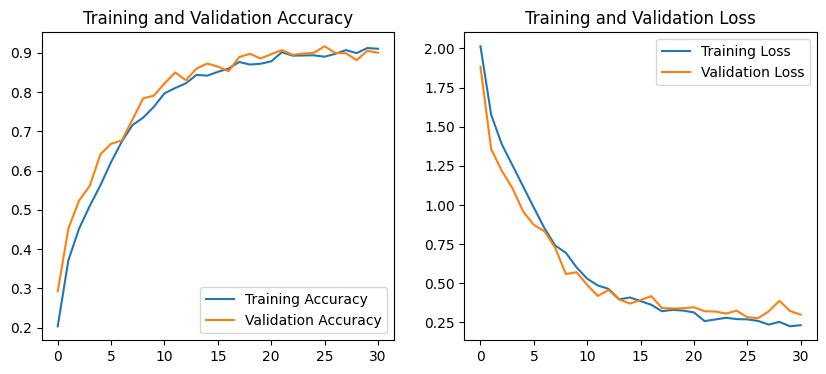

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyzing your results. Did we get rid of underfitting/overfitting? Did class rebalance help?



* The training accuracy is 91% and validation accuracy is 90%, which is a significant improvement from the previous model and the overfitting and underfitting issues have been decently handled.


In [71]:
# Accuracy on Test data is not upto the mark

test_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=(img_width,img_height),
                                                            shuffle=False,batch_size=120)
predictions=model.predict(test_ds)
score = tf.nn.softmax(predictions)
_, labels = tuple(zip(*test_ds))
print(labels)
print()
print(np.argmax(score,axis=-1))
print()

from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(labels[0].numpy(),np.argmax(score,axis=-1))

Found 118 files belonging to 9 classes.
1/1 [==============================] - 4s 4s/step
(<tf.Tensor: shape=(118,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8], dtype=int32)>,)

[4 4 4 4 4 0 5 4 4 4 4 4 4 4 4 4 7 0 1 7 5 5 5 5 1 1 1 3 7 2 1 1 3 3 7 4 3
 5 3 1 1 5 2 2 2 2 5 1 5 3 4 4 5 4 1 5 5 5 4 4 5 4 4 3 4 4 4 3 4 4 4 4 4 4
 5 4 4 4 4 4 5 5 5 5 1 7 3 5 5 5 5 5 1 5 0 6 3 3 3 4 4 4 4 4 7 7 5 7 1 7 7
 5 7 7 7 8 8 8]

Test Accuracy


0.4067796610169492